# Part 3: Thermal Coupling

In [1]:
import os # test commit
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, HTML
from scipy.interpolate import interp2d
from sklearn.metrics import mean_squared_error

try:  # if running with Google Colab
    from google.colab import drive
    drive.mount('/content/drive')

    import sys
    # the location where you saved the tools.py and csv files
    drive_dir = '/content/drive/My Drive/Colab Notebooks/FCTT 3'
    sys.path.insert(0, drive_dir)

    data_dir = os.path.join(drive_dir, 'battery_experimental_data')
    fit_res_dir = os.path.join(drive_dir, 'fitting_results')
except:  # if running locally
    data_dir = os.path.abspath('battery_experimental_data')
    fit_res_dir = os.path.abspath('fitting_results')
    
from tools import *

## Load data

In [2]:
training_data_20 = pd.read_csv(os.path.join(data_dir, 'Model_Training_Data_20.csv'))
SOC_OCV_data = pd.read_csv(os.path.join(data_dir, 'SOC_OCV_MFCTT_2019.csv'), sep='\t')

In [3]:
# extract values in numpy array
ref_SOC = SOC_OCV_data['SOC'].values                   # unit in %
ref_OCV = SOC_OCV_data['Ecell/V'].values               # unit in V

t = training_data_20['Time (s)'].values                # unit in s
I = -training_data_20['Current (A)'].values             # unit in A
V_actual = training_data_20['Voltage (V)'].values      # unit in V

SOC_levels = np.arange(0.9, 0.1, -0.1)
SOC_from_idx_map = {i: SOC_levels[i] for i in range(8)}  # 8 SOC levels

## Model

### Constants

In [4]:
T0 = 293.15
T_env = 293.15
R = 8.31446261815324        # Gas constant
m = 45.0e-3       # Cell mass 45.0 g

c = 825.0         # Specific heat

# Cell Dimensions
height = 64.85e-3
radius = 18.33e-3 / 2

# Cell Surface Area
Area = 2*np.pi*radius*height + 2*np.pi*radius**2

### Functions

In [5]:
def T_change(I, I_R1, R0, R1, dt, T, h):
    dT = ( (I**2 * R0 + I_R1**2 * R1) * dt - h*Area*(T - T_env)*dt) / (m * c)
    T_new = T + dT
    return T_new

You can use below for fit functions, so no need to copy and past everytime parameters change:

In [6]:
def fit_R0(T):
    R0_const, E = read_fit_res(fit_res_dir, 'R0')
    R0_val = R0_const * np.exp(-(E / R)*(1/T - 1/T0))
    return R0_val


def fit_R1(I, T):
    _, b, c, d = read_fit_res(fit_res_dir, 'R1_gauss')
    E = read_fit_res(fit_res_dir, 'R1_arr')
    R1_const = read_fit_res(fit_res_dir, 'R1')
    R1_val = R1_const * np.exp(-((I-b)**2) / c) * np.exp(-(E/R) * (1/T - 1/T0)) + d
    return R1_val


def fit_C1(T):
    C1_const = read_fit_res(fit_res_dir, 'C1')
    C1_val = C1_const
    return C1_val

### Plots

In [7]:
testing_data = pd.read_csv(os.path.join(data_dir, 'Battery_Testing_Data.csv'), header=0, skiprows=[1])

t = testing_data['Time (s)'].values                # unit in s
I = -testing_data['Current (mA)'].values / 1000    # unit in A
V_actual = testing_data['Voltage (V)'].values      # unit in V
T = testing_data['Temperature'].values + 273.15      # unit in K

h = 10
V_pred, T_pred = first_order_ECN_thermal(t, I, T[0], V_actual, ref_OCV, ref_SOC,
                    fit_R0, fit_R1, fit_C1, T_change, h)

h = 33
V_pred_tunned, T_pred_tunned = first_order_ECN_thermal(t, I, T[0], V_actual, ref_OCV, ref_SOC,
                    fit_R0, fit_R1, fit_C1, T_change, h)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


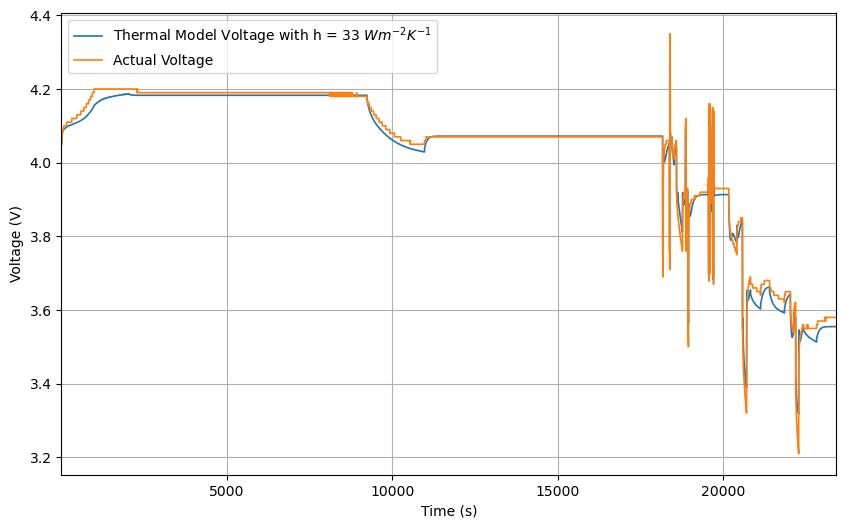

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


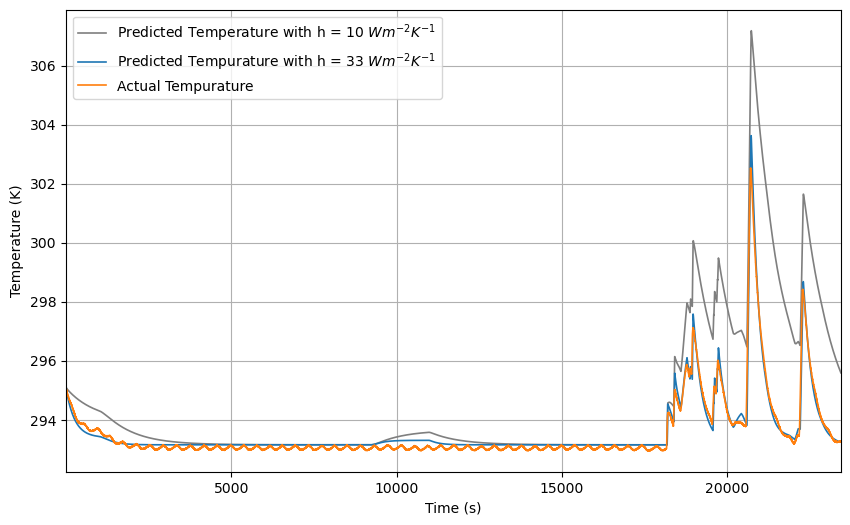

In [8]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(t[:-1], V_pred_tunned, label='Thermal Model Voltage with h = 33 $W m^{-2} K^{-1}$', linewidth=1.2)
ax.plot(t, V_actual, label='Actual Voltage', linewidth=1.2)
ax.legend()
ax.set_xlim([t[0], t[-1]])
ax.set_xlabel('Time (s)')
ax.set_ylabel('Voltage (V)')
# ax.set_title('First Order ECN Model Prediction')
ax.grid()
fig.savefig('Figures/Part 3/part3_V.eps', format='eps')
plt.show()


fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(t, T_pred, label='Predicted Temperature with h = 10 $W m^{-2} K^{-1}$',color='#7f7f7f', linewidth=1.2)
ax.plot(t, T_pred_tunned, label='Predicted Tempurature with h = 33 $W m^{-2} K^{-1}$',color='#1f77b4', linewidth=1.2)
ax.plot(t, T, label='Actual Tempurature',color='#ff7f0e', linewidth=1.2)
ax.legend()
ax.set_xlim([t[0], t[-1]])
ax.set_xlabel('Time (s)')
ax.set_ylabel('Temperature (K)')
# ax.set_title('First Order ECN Model Prediction')
ax.grid()
fig.savefig('Figures/Part 3/part3_T.eps', format='eps')
plt.show()
# :)

#### Error

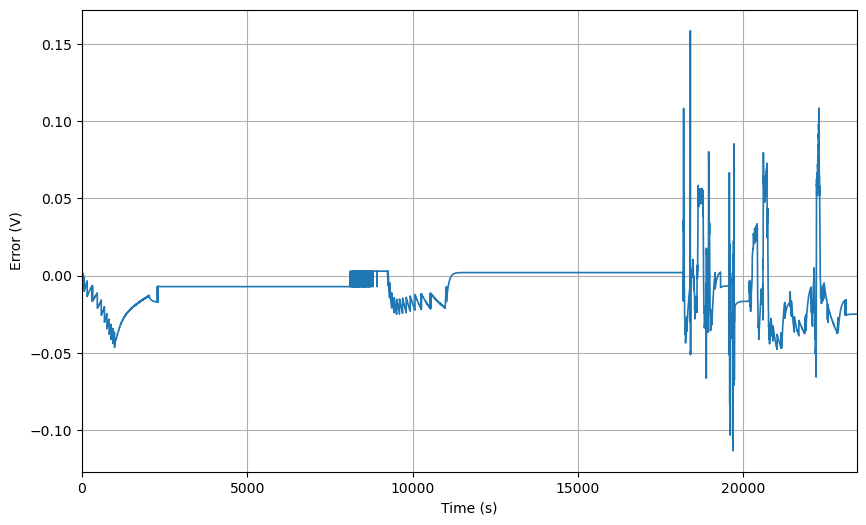

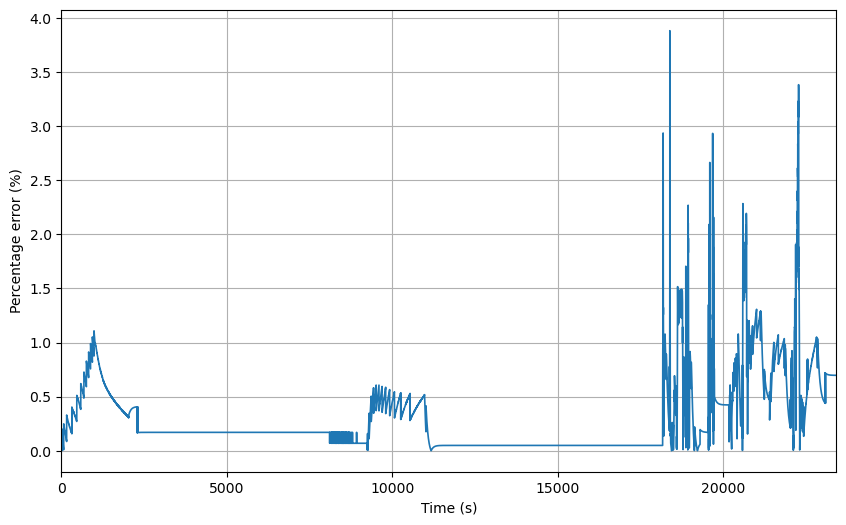

Maximum absolute error is 0.1587 V, at t = 18395 s
Maximum percentage error is 3.8808%, at t = 18395 s
Average absolute error is 0.0116 V
Average absolute error is 0.2965%
RMSE is 0.0170


In [9]:
error = V_pred_tunned - V_actual[:-1]
error_abs = np.abs(V_pred_tunned - V_actual[:-1])
error_pct = np.abs((V_pred_tunned - V_actual[:-1]) / V_actual[:-1])

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(t[:-1], error, linewidth=1.2)
ax.set_xlim([0, t[-1]])
ax.set_xlabel('Time (s)')
ax.set_ylabel('Error (V)')
# ax.set_title('First Order ECN Model Error')
ax.grid()
fig.savefig('Figures/Part 3/part3_V_error.eps', format='eps')
plt.show()

_, ax = plt.subplots(figsize=(10, 6))
ax.plot(t[:-1], error_pct*100, linewidth=1.2)
ax.set_xlim([0, t[-1]])
ax.set_xlabel('Time (s)')
ax.set_ylabel('Percentage error (%)')
# ax.set_title('First Order ECN Model Error')
ax.grid()
plt.show()


max_err = np.max(error_abs)
max_idx = np.argmax(error_abs)
t_max_err = t[max_idx]

print("Maximum absolute error is {:.4f} V, at t = {} s".format(max_err, t_max_err))

max_err = np.max(error_pct)
max_idx = np.argmax(error_pct)
t_max_err = t[max_idx]

print("Maximum percentage error is {:.4f}%, at t = {} s".format(max_err*100, t_max_err))

avg_err = np.mean(error_abs)

print("Average absolute error is {:.4f} V".format(avg_err))

avg_err = np.mean(error_pct)

print("Average absolute error is {:.4f}%".format(avg_err*100))

rmse = mean_squared_error(V_actual[:-1], V_pred_tunned, squared=False)

print("RMSE is {:.4f}".format(rmse))


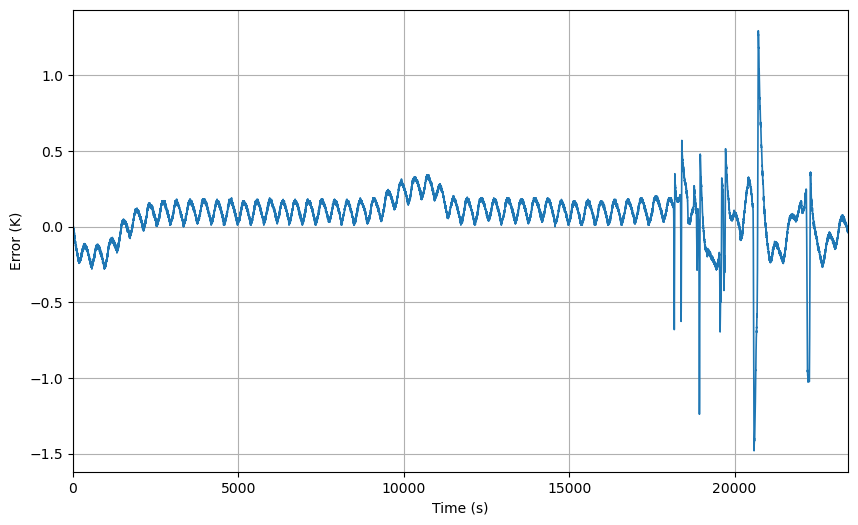

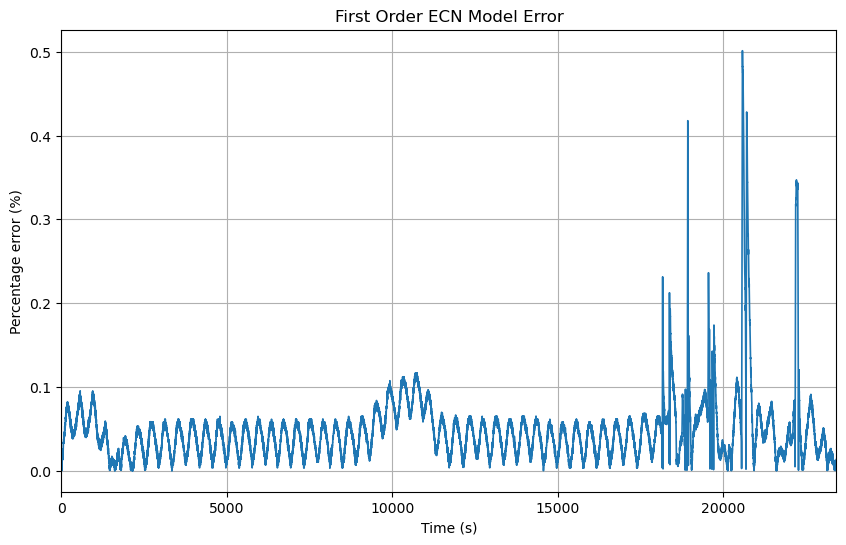

Maximum absolute error is 1.4804 K, at t = 20590 s
Maximum percentage error is 0.5013%, at t = 20590 s
Average absolute error is 0.1399 K
Average absolute error is 0.0476%
RMSE is 0.1879


In [10]:
error = T_pred_tunned - T
error_abs = np.abs(T_pred_tunned - T)
error_pct = np.abs((T_pred_tunned - T) / T)

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(t, error, linewidth=1.2)
ax.set_xlim([0, t[-1]])
ax.set_xlabel('Time (s)')
ax.set_ylabel('Error (K)')
# ax.set_title('First Order ECN Model Error')
ax.grid()
fig.savefig('Figures/Part 3/part3_T_error.eps', format='eps')
plt.show()

_, ax = plt.subplots(figsize=(10, 6))
ax.plot(t, error_pct*100, linewidth=1.2)
ax.set_xlim([0, t[-1]])
ax.set_xlabel('Time (s)')
ax.set_ylabel('Percentage error (%)')
ax.set_title('First Order ECN Model Error')
ax.grid()
plt.show()


max_err = np.max(error_abs)
max_idx = np.argmax(error_abs)
t_max_err = t[max_idx]

print("Maximum absolute error is {:.4f} K, at t = {} s".format(max_err, t_max_err))

max_err = np.max(error_pct)
max_idx = np.argmax(error_pct)
t_max_err = t[max_idx]

print("Maximum percentage error is {:.4f}%, at t = {} s".format(max_err*100, t_max_err))

avg_err = np.mean(error_abs)

print("Average absolute error is {:.4f} K".format(avg_err))

avg_err = np.mean(error_pct)

print("Average absolute error is {:.4f}%".format(avg_err*100))

rmse = mean_squared_error(T, T_pred_tunned, squared=False)

print("RMSE is {:.4f}".format(rmse))